# Install Dependencies

In [ ]:
%%capture
%pip install torch_geometric torch pandas wandb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

# Create a directory in your Google Drive
workdir = '/content/drive/MyDrive/Colab Notebooks/stock_dgt/'

# Remove and recreate directory
if os.path.exists(workdir):
    shutil.rmtree(workdir)
os.makedirs(workdir)

KeyboardInterrupt: 

# Dataset Construction

## Download Dataset

In [ ]:
# Clone the repository to download the S&P500 stock prices, precomputed correlation matrcies,
# along with trained model weights for ease of evaluation
!git clone https://github.com/AlienKevin/sp500.git

import shutil
import os

repo_name = "sp500"
# for file_name in os.listdir(repo_name):
#     shutil.move(os.path.join(repo_name, file_name), workdir)

# Remove the cloned repository folder
# shutil.rmtree(repo_name)

Cloning into 'sp500'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 125 (delta 0), reused 21 (delta 0), pack-reused 85 (from 1)
Receiving objects: 100% (125/125), 187.45 MiB | 23.74 MiB/s, done.
Updating files: 100% (99/99), done.


In [ ]:
workdir = '/content/sp500'
print(workdir)

/content/sp500


## Exploratory Data Analysis Shows Superiority of Mutual Information in Capturing Interstock Relationships

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Plot the 3 most correlated stocks to the target_stock based on corr_name with scope corr_scope
def plot_most_correlated_stocks(target_stock, corr_name, corr_scope):
    df = pd.read_csv(f'{workdir}/sp500.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')

    target_index = df.columns.get_loc(target_stock)

    corr = np.loadtxt(f'{workdir}/{corr_name}/{corr_scope}.csv', delimiter=',')

    top_3_correlated_indices = corr[target_index].argsort()[-4:][::-1]
    top_3_correlated_stocks = df.columns[top_3_correlated_indices]

    plt.clf()
    plt.figure(figsize=(12, 6))
    plt.style.use('default')

    for stock in top_3_correlated_stocks:
        if corr_scope.startswith('global'):
            # Plot the entire duration of the dataset for global correlations
            plt.plot(df.index, df[stock], label=stock)
        else:
            # Only plot the time window corresponding to the local correlations
            num_days_in_quarter = 64
            quarter_index = int(corr_scope.split('_')[-1])
            quarter_start_index = quarter_index * num_days_in_quarter
            quarter_end_index = (quarter_index + 1) * num_days_in_quarter
            print('Quarter Start date', df.index[quarter_start_index])
            print('Quarter End date', df.index[quarter_end_index])
            quarter_df = df.iloc[quarter_start_index:quarter_end_index]
            plt.plot(quarter_df.index, quarter_df[stock], label=stock)

    plt.title(f"Top 3 Correlated Stocks with {top_3_correlated_stocks[0]} using {'Global' if corr_scope.startswith('global') else 'Local'} {'Pearson' if corr_name == 'pcc' else 'Mutual Information'}: {', '.join(top_3_correlated_stocks[1:])}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


## Global Mutual Information Captures Shared Trends Well

<Figure size 640x480 with 0 Axes>

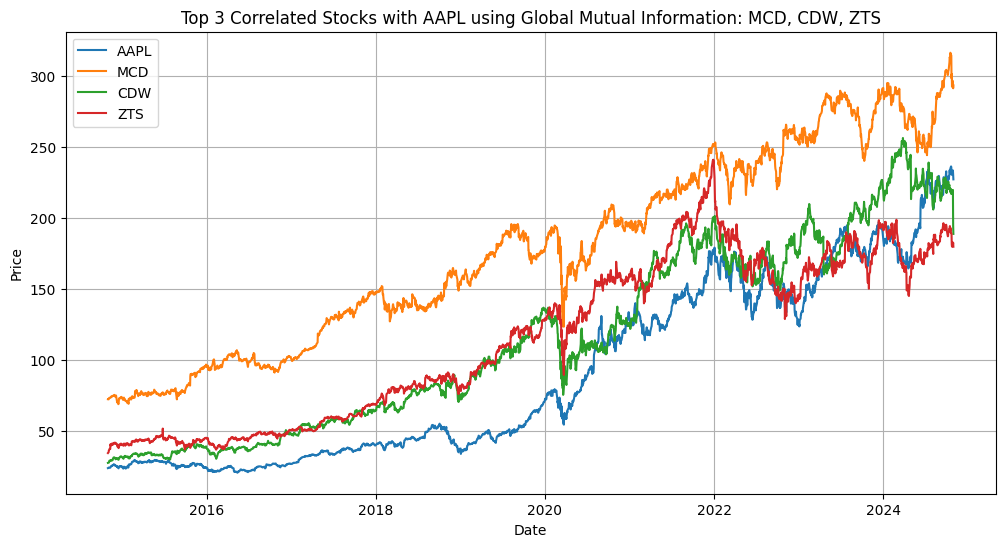

In [ ]:
plot_most_correlated_stocks('AAPL', 'mi', 'global_corr')

## Global Pearson Struggles with Nonlinearity in the Market

<Figure size 640x480 with 0 Axes>

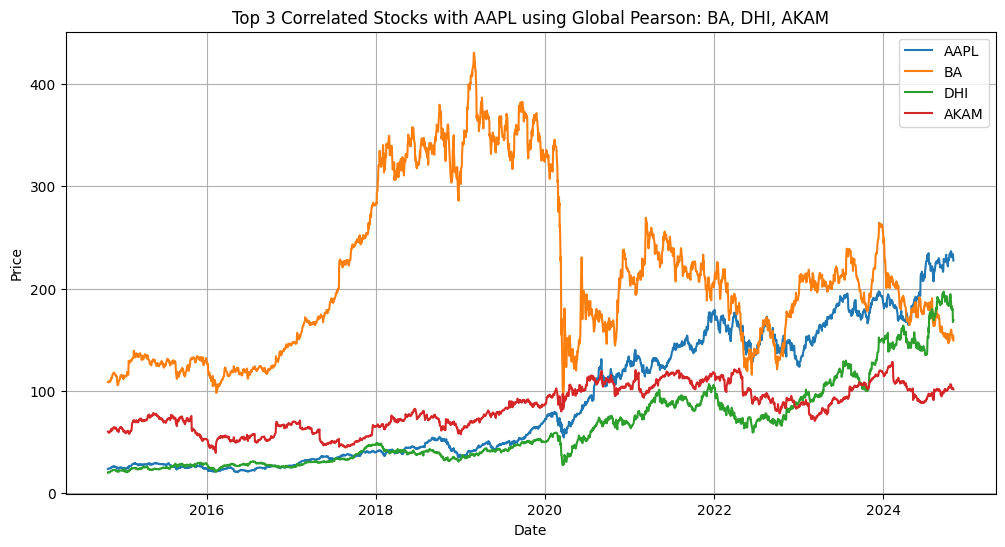

In [ ]:
plot_most_correlated_stocks('AAPL', 'pcc', 'global_corr')

## Mutual Information and Pearson Perform Similarly Well on a Local Scope (the Length of 1 Fiscal Quarter)

Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00


<Figure size 640x480 with 0 Axes>

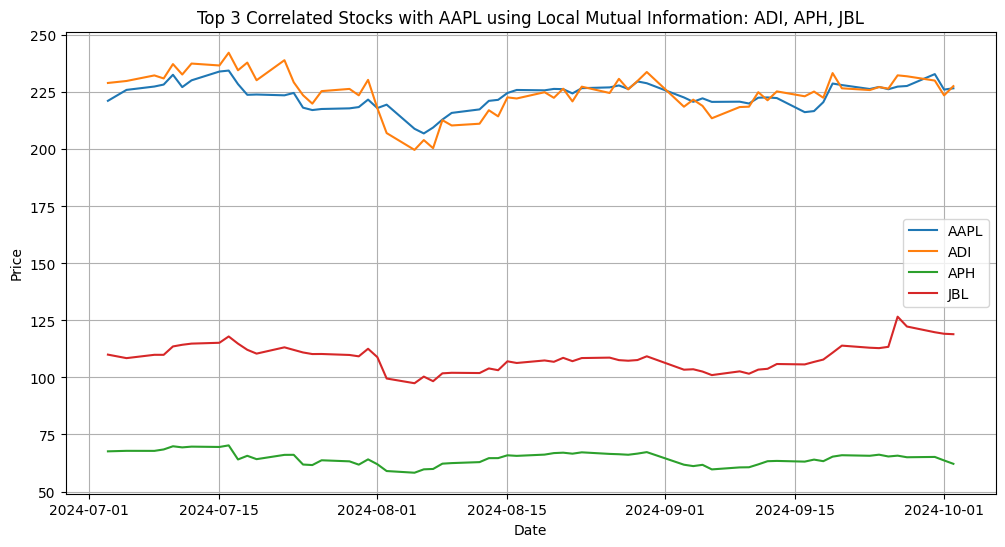

In [ ]:
plot_most_correlated_stocks('AAPL', 'mi', 'local_corr_38')

Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00


<Figure size 640x480 with 0 Axes>

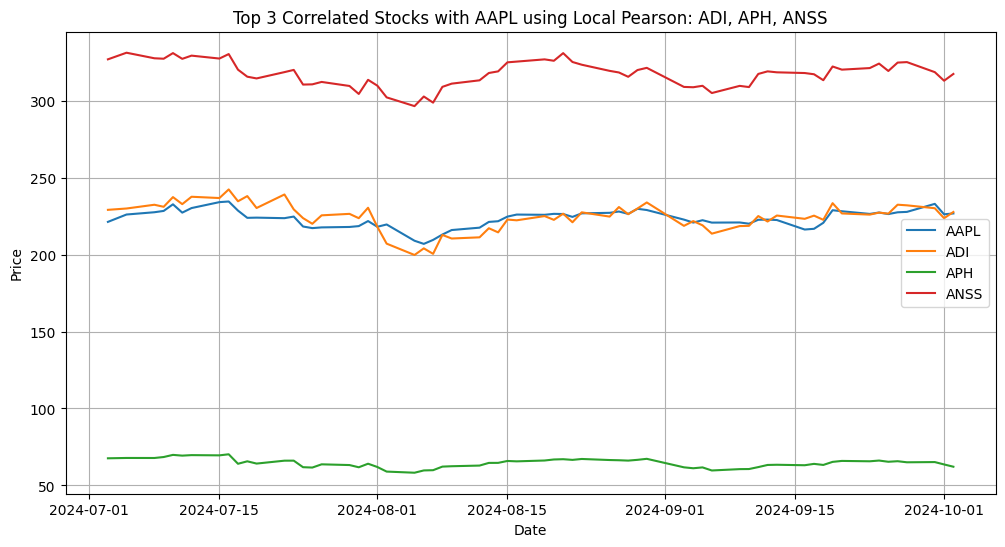

In [ ]:
plot_most_correlated_stocks('AAPL', 'pcc', 'local_corr_38')

## Construct Temporal PyG Dataset

In [ ]:
# Copied from PyG temporal rather than imported because the library has dependency issues with PyG
# https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/signal/dynamic_graph_temporal_signal.html

from typing import Sequence, Union
import numpy as np

Edge_Indices = Sequence[Union[np.ndarray, None]]
Edge_Weights = Sequence[Union[np.ndarray, None]]
Node_Features = Sequence[Union[np.ndarray, None]]
Targets = Sequence[Union[np.ndarray, None]]
Additional_Features = Sequence[np.ndarray]

class DynamicGraphTemporalSignal(object):
    r"""A data iterator object to contain a dynamic graph with a
    changing edge set and weights . The feature set and node labels
    (target) are also dynamic. The iterator returns a single discrete temporal
    snapshot for a time period (e.g. day or week). This single snapshot is a
    Pytorch Geometric Data object. Between two temporal snapshots the edges,
    edge weights, target matrices and optionally passed attributes might change.

    Args:
        edge_indices (Sequence of Numpy arrays): Sequence of edge index tensors.
        edge_weights (Sequence of Numpy arrays): Sequence of edge weight tensors.
        features (Sequence of Numpy arrays): Sequence of node feature tensors.
        targets (Sequence of Numpy arrays): Sequence of node label (target) tensors.
        **kwargs (optional Sequence of Numpy arrays): Sequence of additional attributes.
    """

    def __init__(
        self,
        edge_indices: Edge_Indices,
        edge_weights: Edge_Weights,
        features: Node_Features,
        targets: Targets,
        **kwargs: Additional_Features
    ):
        self.edge_indices = edge_indices
        self.edge_weights = edge_weights
        self.features = features
        self.targets = targets
        self.additional_feature_keys = []
        for key, value in kwargs.items():
            setattr(self, key, value)
            self.additional_feature_keys.append(key)
        self._check_temporal_consistency()
        self._set_snapshot_count()

    def _check_temporal_consistency(self):
        assert len(self.features) == len(
            self.targets
        ), "Temporal dimension inconsistency."
        assert len(self.edge_indices) == len(
            self.edge_weights
        ), "Temporal dimension inconsistency."
        assert len(self.features) == len(
            self.edge_weights
        ), "Temporal dimension inconsistency."
        for key in self.additional_feature_keys:
            assert len(self.targets) == len(
                getattr(self, key)
            ), "Temporal dimension inconsistency."

    def _set_snapshot_count(self):
        self.snapshot_count = len(self.features)

    def _get_edge_index(self, time_index: int):
        if self.edge_indices[time_index] is None:
            return self.edge_indices[time_index]
        else:
            return torch.LongTensor(self.edge_indices[time_index])

    def _get_edge_weight(self, time_index: int):
        if self.edge_weights[time_index] is None:
            return self.edge_weights[time_index]
        else:
            return torch.FloatTensor(self.edge_weights[time_index])

    def _get_features(self, time_index: int):
        if self.features[time_index] is None:
            return self.features[time_index]
        else:
            return torch.FloatTensor(self.features[time_index])

    def _get_target(self, time_index: int):
        if self.targets[time_index] is None:
            return self.targets[time_index]
        else:
            if self.targets[time_index].dtype.kind == "i":
                return torch.LongTensor(self.targets[time_index])
            elif self.targets[time_index].dtype.kind == "f":
                return torch.FloatTensor(self.targets[time_index])

    def _get_additional_feature(self, time_index: int, feature_key: str):
        feature = getattr(self, feature_key)[time_index]
        if feature.dtype.kind == "i":
            return torch.LongTensor(feature)
        elif feature.dtype.kind == "f":
            return torch.FloatTensor(feature)

    def _get_additional_features(self, time_index: int):
        additional_features = {
            key: self._get_additional_feature(time_index, key)
            for key in self.additional_feature_keys
        }
        return additional_features

    def __getitem__(self, time_index: Union[int, slice]):
        if isinstance(time_index, slice):
            snapshot = DynamicGraphTemporalSignal(
                self.edge_indices[time_index],
                self.edge_weights[time_index],
                self.features[time_index],
                self.targets[time_index],
                **{key: getattr(self, key)[time_index] for key in self.additional_feature_keys}
            )
        else:
            x = self._get_features(time_index)
            edge_index = self._get_edge_index(time_index)
            edge_weight = self._get_edge_weight(time_index)
            y = self._get_target(time_index)
            additional_features = self._get_additional_features(time_index)

            snapshot = Data(x=x, edge_index=edge_index, edge_attr=edge_weight,
                            y=y, **additional_features)
        return snapshot

    def __next__(self):
        if self.t < len(self.features):
            snapshot = self[self.t]
            self.t = self.t + 1
            return snapshot
        else:
            self.t = 0
            raise StopIteration

    def __iter__(self):
        self.t = 0
        return self

In [ ]:
# Copied from PyG temporal rather than imported because the library has dependency issues with PyG
# https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/signal/static_graph_temporal_signal.html#StaticGraphTemporalSignal
import torch
import numpy as np
from typing import Sequence, Union
from torch_geometric.data import Data


Edge_Index = Union[np.ndarray, None]
Edge_Weight = Union[np.ndarray, None]
Node_Features = Sequence[Union[np.ndarray, None]]
Targets = Sequence[Union[np.ndarray, None]]
Additional_Features = Sequence[np.ndarray]

class StaticGraphTemporalSignal(object):
    r"""A data iterator object to contain a static graph with a dynamically
    changing constant time difference temporal feature set (multiple signals).
    The node labels (target) are also temporal. The iterator returns a single
    constant time difference temporal snapshot for a time period (e.g. day or week).
    This single temporal snapshot is a Pytorch Geometric Data object. Between two
    temporal snapshots the features and optionally passed attributes might change.
    However, the underlying graph is the same.

    Args:
        edge_index (Numpy array): Index tensor of edges.
        edge_weight (Numpy array): Edge weight tensor.
        features (Sequence of Numpy arrays): Sequence of node feature tensors.
        targets (Sequence of Numpy arrays): Sequence of node label (target) tensors.
        **kwargs (optional Sequence of Numpy arrays): Sequence of additional attributes.
    """

    def __init__(
        self,
        edge_index: Edge_Index,
        edge_weight: Edge_Weight,
        features: Node_Features,
        targets: Targets,
        **kwargs: Additional_Features
    ):
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        self.features = features
        self.targets = targets
        self.additional_feature_keys = []
        for key, value in kwargs.items():
            setattr(self, key, value)
            self.additional_feature_keys.append(key)
        self._check_temporal_consistency()
        self._set_snapshot_count()

    def _check_temporal_consistency(self):
        assert len(self.features) == len(
            self.targets
        ), "Temporal dimension inconsistency."
        for key in self.additional_feature_keys:
            assert len(self.targets) == len(
                getattr(self, key)
            ), "Temporal dimension inconsistency."

    def _set_snapshot_count(self):
        self.snapshot_count = len(self.features)

    def _get_edge_index(self):
        if self.edge_index is None:
            return self.edge_index
        else:
            return torch.LongTensor(self.edge_index)

    def _get_edge_weight(self):
        if self.edge_weight is None:
            return self.edge_weight
        else:
            return torch.FloatTensor(self.edge_weight)

    def _get_features(self, time_index: int):
        if self.features[time_index] is None:
            return self.features[time_index]
        else:
            return torch.FloatTensor(self.features[time_index])

    def _get_target(self, time_index: int):
        if self.targets[time_index] is None:
            return self.targets[time_index]
        else:
            if self.targets[time_index].dtype.kind == "i":
                return torch.LongTensor(self.targets[time_index])
            elif self.targets[time_index].dtype.kind == "f":
                return torch.FloatTensor(self.targets[time_index])

    def _get_additional_feature(self, time_index: int, feature_key: str):
        feature = getattr(self, feature_key)[time_index]
        if feature.dtype.kind == "i":
            return torch.LongTensor(feature)
        elif feature.dtype.kind == "f":
            return torch.FloatTensor(feature)

    def _get_additional_features(self, time_index: int):
        additional_features = {
            key: self._get_additional_feature(time_index, key)
            for key in self.additional_feature_keys
        }
        return additional_features

    def __getitem__(self, time_index: Union[int, slice]):
        if isinstance(time_index, slice):
            snapshot = StaticGraphTemporalSignal(
                self.edge_index,
                self.edge_weight,
                self.features[time_index],
                self.targets[time_index],
                **{key: getattr(self, key)[time_index] for key in self.additional_feature_keys}
            )
        else:
            x = self._get_features(time_index)
            edge_index = self._get_edge_index()
            edge_weight = self._get_edge_weight()
            y = self._get_target(time_index)
            additional_features = self._get_additional_features(time_index)

            snapshot = Data(x=x, edge_index=edge_index, edge_attr=edge_weight,
                            y=y, **additional_features)
        return snapshot

    def __next__(self):
        if self.t < len(self.features):
            snapshot = self[self.t]
            self.t = self.t + 1
            return snapshot
        else:
            self.t = 0
            raise StopIteration

    def __iter__(self):
        self.t = 0
        return self

In [ ]:
import numpy as np
import pandas as pd
import torch
from typing import Union
import glob
from natsort import natsorted
import random

# Fix random seed for ease of reproduction
seed = 42
random.seed(seed)
torch.manual_seed(seed)

# Dataset loader for SP500 stock prices
class SP500CorrelationsDatasetLoader(object):
    def __init__(self, corr_name, corr_scope):
        self._read_csv(corr_name, corr_scope)

    # Load a global correlation under the name corr_name
    def _load_global_corr(self, corr_name):
        return np.loadtxt(f'{workdir}/{corr_name}/global_corr.csv', delimiter=',')

    # Load a local correlation under the name corr_name
    def _load_local_corrs(self, corr_name):
        _correlation_matrices = []
        corr_files = natsorted(glob.glob(f'{workdir}/{corr_name}/local_corr_*.csv'))
        for corr_file in corr_files:
            matrix = np.loadtxt(corr_file, delimiter=',')
            _correlation_matrices.append(matrix)
        return _correlation_matrices

    # Helper function for reading a correlation with type corr_name and scope corr_scope from CSV file
    def _read_csv(self, corr_name, corr_scope):
        match corr_scope:
            case 'global':
                self._correlation_matrices = [self._load_global_corr(corr_name)]
            case 'local':
                self._correlation_matrices = self._load_local_corrs(corr_name)
            case 'dual':
                # Stack global and local correlation matrices for dual correlation
                global_corr = self._load_global_corr(corr_name)
                self._correlation_matrices = [np.stack((global_corr, local_corr), axis=-1) for local_corr in self._load_local_corrs(corr_name)]
            case None:
                # None uses identity matrix as correlation
                # Infer dimension from a global correlation matrix
                global_corr = self._load_global_corr('pcc')
                self._correlation_matrices = [np.eye(global_corr.shape[0], global_corr.shape[1])]

        if corr_name == 'mi':
            # Normalize MI to [0, 1]
            max_mi = 0
            for matrix in self._correlation_matrices:
                max_mi = max(np.max(matrix), max_mi)
                # MI shouldn't be negative
                matrix[matrix < 0] = 0
            for matrix in self._correlation_matrices:
                matrix = matrix / max_mi

        df = pd.read_csv(f'{workdir}/sp500.csv')
        df = df.set_index('Date')
        data = torch.from_numpy(df.to_numpy()).to(torch.float32)

        # Round data size to nearest multiple of batch_size
        self.days_in_quarter = 64
        num_quarters = data.size(0) // self.days_in_quarter
        num_days = num_quarters * self.days_in_quarter
        data = data[:num_days]

        # z-score normalization with training data following GERU
        train_days = int(0.8 * num_quarters) * self.days_in_quarter
        data = (data - data[:train_days].mean(dim=0)) / data[:train_days].std(dim=0)
        data = data.numpy()

        data = data[..., np.newaxis]

        assert(not np.any(np.isnan(data)))
        self._dataset = data

    def _get_edges(self, times, overlap):
        # Construct a fully-connected graph
        def helper(corr_index):
            return np.array(np.ones(self._correlation_matrices[corr_index].shape[:2]).nonzero())

        if len(self._correlation_matrices) == 1:
            _edges = helper(0)
        else:
            _edges = []
            for time in range(0, self._dataset.shape[0] - self.batch_size, overlap):
                if not time in times:
                    continue
                corr_index = max(0, time // self.days_in_quarter - 1)
                _edges.append(
                    helper(corr_index)
                )
        return _edges

    def _get_edge_weights(self, times, overlap):
        # Edge weights are the correlations between stocks
        def helper(corr_index):
            w = self._correlation_matrices[corr_index]
            # Flatten the first two dimensions
            return w.reshape((w.shape[0] * w.shape[1],) + w.shape[2:])

        if len(self._correlation_matrices) == 1:
            _edge_weights = helper(0)
        else:
            _edge_weights = []
            for time in range(0, self._dataset.shape[0] - self.batch_size, overlap):
                if not time in times:
                    continue
                corr_index = max(0, time // self.days_in_quarter - 1)
                _edge_weights.append(
                    helper(corr_index)
                )
        return _edge_weights

    def _get_targets_and_features(self, times, overlap, predict_all):
        # Given previous batch_size stock prices...
        features = [
            self._dataset[i : i + self.batch_size, :]
            for i in range(0, self._dataset.shape[0] - self.batch_size, overlap)
            if i in times
        ]
        # predict next-day stock prices
        targets = [
            (self._dataset[i+1 : i + self.batch_size+1, :, 0]).T if predict_all else (self._dataset[i + self.batch_size, :, 0]).T
            for i in range(0, self._dataset.shape[0] - self.batch_size, overlap)
            if i in times
        ]
        return features, targets

    def get_dataset(self, batch_size, split) -> Union[StaticGraphTemporalSignal, DynamicGraphTemporalSignal]:
        # Returning the data iterator where the train is designed for many-to-many predictions (each day predict next day's price)
        # while the validation and test are many-to-one predictions (many past days predict tomorrow's price)

        self.batch_size = batch_size

        total_times = list(range(0, self._dataset.shape[0] - self.batch_size, self.batch_size))

        # We do a 8-1-1 split for train-validation-test. Since the test set is one year apart from training,
        # It is much more challenging to predict.
        if split == 'train':
            times = list(range(total_times[int(len(total_times) * 0)], total_times[int(len(total_times) * 0.8)]))
            overlap = self.batch_size
            predict_all = True
        elif split == 'val':
            times = list(range(total_times[int(len(total_times) * 0.8)], total_times[int(len(total_times) * 0.9)]))
            overlap = 1
            predict_all = False
        elif split == 'test':
            times = list(range(total_times[int(len(total_times) * 0.9)], total_times[-1] + self.batch_size))
            overlap = 1
            predict_all = False
        else:
            raise ValueError(f'Invalid split name: {split}')

        _edges = self._get_edges(times, overlap)
        _edge_weights = self._get_edge_weights(times, overlap)
        features, targets = self._get_targets_and_features(times, overlap, predict_all)
        dataset = (DynamicGraphTemporalSignal if type(_edges) == list else StaticGraphTemporalSignal)(
            _edges, _edge_weights, features, targets
        )
        return dataset

# Helper function to get the dataset for a correlation
def get_dataset(corr_name, corr_scope):
    loader = SP500CorrelationsDatasetLoader(corr_name=corr_name, corr_scope=corr_scope)

    lag_size = 64
    # Train dataset has double the batch_size because it's trained under many-to-many prediction.
    # During test time, the model is used for many-to-one prediction given batch_size previous days.
    # Hence, we need to have a larger training batch_size than the lag_size during test.
    train_dataset = loader.get_dataset(batch_size=lag_size * 2, split='train')
    val_dataset = loader.get_dataset(batch_size=lag_size, split='val')
    test_dataset = loader.get_dataset(batch_size=lag_size, split='test')

    train_samples = list(train_dataset)
    val_samples = list(val_dataset)
    test_samples = list(test_dataset)

    return {
        'train_samples': train_samples,
        'val_samples': val_samples,
        'test_samples': test_samples,
    }

# example of usage
dataset = get_dataset('pcc', 'global')
# shape of the dataset
print(dataset['train_samples'][0])

In [ ]:
# Helper function to get the dataset for a correlation
def get_dataset(corr_name, corr_scope):
    loader = SP500CorrelationsDatasetLoader(corr_name=corr_name, corr_scope=corr_scope)

    lag_size = 64
    # Train dataset has double the batch_size because it's trained under many-to-many prediction.
    # During test time, the model is used for many-to-one prediction given batch_size previous days.
    # Hence, we need to have a larger training batch_size than the lag_size during test.
    train_dataset = loader.get_dataset(batch_size=lag_size * 2, split='train')
    val_dataset = loader.get_dataset(batch_size=lag_size, split='val')
    test_dataset = loader.get_dataset(batch_size=lag_size, split='test')

    train_samples = list(train_dataset)
    val_samples = list(val_dataset)
    test_samples = list(test_dataset)

    return {
        'train_samples': train_samples,
        'val_samples': val_samples,
        'test_samples': test_samples,
    }

# example of usage
dataset = get_dataset('pcc', 'global')
# shape of the dataset
print(dataset['train_samples'][0])


Data(x=[128, 472, 1], edge_index=[2, 222784], edge_attr=[222784], y=[472, 128])


## Adapting to model training

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Graph filter class module for pytorch
class GraphFilter(nn.Module):
    def __init__(self, GSO):
        super().__init__()
        self.register_buffer('GSO', torch.tensor(GSO, dtype=torch.float32))
        deg = torch.sum(self.GSO, dim=1, keepdim=True) + 1e-6    # [N,1]
        self.register_buffer('inv_degree', (1.0/deg).t())       # [1,N]

    def forward(self, x):
        # x: [batch*seq, N]
        out = x @ self.GSO         # [batch*seq, N]
        return out * self.inv_degree  # normalize

## Model

### Baseline LSTM

In [ ]:
# Baseline LSTM model without graph filtering
class Baseline_LSTM(nn.Module):
    def __init__(self, num_nodes, hidden_dim):
        super().__init__()
        # Input feature size for LSTM is directly num_nodes
        self.lstm = nn.LSTM(num_nodes, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_nodes)

    def forward(self, x):
        # x shape: [batch, seq, nodes]
        # Pass x directly to LSTM
        out, _ = self.lstm(x)

        # out shape: [batch, seq, hidden_dim]
        # Take output from the last time step
        pred = self.fc(out[:, -1, :])

        # pred shape: [batch, num_nodes]
        return pred

### GraphLSTM *Hybrid*

This is an implementation of graph LSTM in its hybrid form - which means that first we apply the filter to the signal then the LSTM to the signal. In this case we use a simple graph filter which aggregates information from 1-hop neightbor.

In [ ]:
class Graph_LSTM(nn.Module):
    """
    Graph-LSTM: applies a GraphFilter per time step, then feeds into an LSTM.
    Fully vectorized over the time dimension for speed.
    """
    def __init__(self, num_nodes, hidden_dim, GSO):
        super().__init__()
        self.filter = GraphFilter(GSO)
        self.lstm   = nn.LSTM(num_nodes, hidden_dim, batch_first=True)
        self.fc     = nn.Linear(hidden_dim, num_nodes)

    def forward(self, x):
        """
        x: [batch, seq, nodes]
        returns: [batch, nodes] (prediction for next step)
        """
        batch, seq, nodes = x.shape

        # flatten batch & seq, apply graph filter in one go
        x_flat = x.view(batch * seq, nodes)         # [B*S, N]
        x_filt = self.filter(x_flat)                # [B*S, N]

        # reshape back into sequence
        x_seq  = x_filt.view(batch, seq, nodes)     # [B, S, N]

        # run through LSTM and predict from last hidden
        out, _ = self.lstm(x_seq)                   # out: [B, S, H]
        last   = out[:, -1, :]                      # [B, H]
        return self.fc(last)                        # [B, N]

### Graph LSTM Parametrized

This an implementation of Graph LSTM which is *parametrized*, which means that we substitue the weight matrices of the LSTM **gates with graph filters.** Also, in this case, we are using a 1-hop filter.

In [ ]:
class GraphLSTMCell(nn.Module):
    """
    LSTM cell where input-to-gate and hidden-to-gate transforms
    are polynomial graph filters of order K on graph shift operator GSO.
    Replaces dense W_x and W_h with Graph Shift Operator powers.

    [TO DO IN FUTURE: Replace this with the class polynomial shift operator that i wrote]
    """

    def __init__(self, GSO, hidden_size, K=2):
        super().__init__()
        N = GSO.shape[0]
        self.hidden_size = hidden_size
        self.K = K

        # register the shift operator and its powers as buffers
        GSO_tensor = torch.tensor(GSO, dtype=torch.float32)
        self.register_buffer('GSO', GSO_tensor)
        powers = [torch.matrix_power(GSO_tensor, k) for k in range(K+1)]
        self.register_buffer('powers', torch.stack(powers, dim=0))  # [K+1, N, N]

        # rraph filter coefficients for input and hidden, for all 4 gates
        # rhape: [4 gates, K+1 coefficients]
        self.theta_x = nn.Parameter(torch.zeros(4, K+1))
        self.theta_h = nn.Parameter(torch.zeros(4, K+1))
        # rate biases (4 * hidden_size)
        self.bias = nn.Parameter(torch.zeros(4 * hidden_size))

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.uniform_(self.theta_x, -0.1, 0.1)
        nn.init.uniform_(self.theta_h, -0.1, 0.1)
        nn.init.zeros_(self.bias)

    def forward(self, x, hx):
        """
        x: [batch, N] node features at time t
        hx: (h, c) each [batch, hidden_size]
        returns: (h_next, c_next)
        """
        h, c = hx
        B, N = x.shape
        H = self.hidden_size
        # ensuring hidden_size matches number of nodes for pure graph filtering
        assert H == N, "hidden_size must equal num_nodes for GraphLSTM"

        # eompute GSO^k x and GSO^k h: shapes [K+1, batch, N]
        #    using einsum: powers[k] @ x^T (N,N) @ (N,B) (N,B)
        filtered_x = torch.einsum('kij,bj->kb i', self.powers, x)
        filtered_h = torch.einsum('kij,bj->kb i', self.powers, h)

        # weight and sum over k for each of the 4 gates
        #    gates_x: [4, batch, N], gates_h: [4, batch, N]
        gates_x = torch.einsum('ik,kbj->ibj', self.theta_x, filtered_x)
        gates_h = torch.einsum('ik,kbj->ibj', self.theta_h, filtered_h)

        # sum, add bias, reshape to [batch, 4*N]
        gates = gates_x + gates_h        # [4, B, N]
        gates = gates.permute(1, 0, 2)    # [B, 4, N]
        gates = gates.reshape(B, 4 * N)   # [B, 4*N]
        gates = gates + self.bias        # broadcast bias

        # split into the four gates
        i, f, g, o = gates.chunk(4, dim=1)
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        g = torch.tanh(g)
        o = torch.sigmoid(o)

        # LSTM cell update
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next


class GraphLSTM(nn.Module):
    """
    Sequence model using the GraphLSTMCell.
    """
    def __init__(self, GSO, hidden_size, K=2):
        super().__init__()
        self.cell = GraphLSTMCell(GSO, hidden_size, K)
        self.hidden_size = hidden_size

    def forward(self, x, hx=None):
        """
        x: [batch, seq, nodes]
        hx: optional initial (h0, c0), each [batch, hidden_size]
        returns: (out_seq, (h_n, c_n))
        """
        B, GSO_len, N = x.shape
        if hx is None:
            h = x.new_zeros(B, self.hidden_size)
            c = x.new_zeros(B, self.hidden_size)
        else:
            h, c = hx

        outputs = []

        for t in range(GSO_len):
            h, c = self.cell(x[:, t, :], (h, c))
            outputs.append(h.unsqueeze(1))
        out_seq = torch.cat(outputs, dim=1)  # [B, S_len, N]
        return out_seq, (h, c)


class Graph_LSTM_Parametrized(nn.Module):
    """
    GraphLSTM-based next-step predictor.
    """
    def __init__(self, GSO, hidden_size, K=2):
        super().__init__()
        self.glstm = GraphLSTM(GSO, hidden_size, K)
        # Final readout: map hidden_size (== nodes) back to node predictions
        self.fc = nn.Linear(hidden_size, GSO.shape[0])

    def forward(self, x):
        """
        x: [batch, seq, nodes]
        returns: [batch, nodes]  next-step prediction
        """
        out_seq, _ = self.glstm(x)       # [B, seq, N]
        last = out_seq[:, -1, :]         # [B, N]
        return self.fc(last)             # [B, N]

### Graph xLSTM *Hybrid*

This is an implementation of graph xLSTM in an *hybrid* version, which means tha first we apply a graph convolution over the signal and then xLSTM over the output of the graph convolution.

In [ ]:
# a single xLSTM cell with low-rank weight factorization
class xLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, rank):
        super().__init__()
        self.input_size, self.hidden_size, self.rank = input_size, hidden_size, rank
        # input-to-gate factors
        self.Wxu = nn.Parameter(torch.Tensor(input_size, rank))
        self.Wxv = nn.Parameter(torch.Tensor(rank, 4 * hidden_size))
        # hidden-to-gate factors
        self.Whu = nn.Parameter(torch.Tensor(hidden_size, rank))
        self.Whv = nn.Parameter(torch.Tensor(rank, 4 * hidden_size))
        # gate biases
        self.bias = nn.Parameter(torch.zeros(4 * hidden_size))
        self.reset_parameters()

    def reset_parameters(self):
        # xavier init for factors
        nn.init.xavier_uniform_(self.Wxu)
        nn.init.xavier_uniform_(self.Wxv)
        nn.init.xavier_uniform_(self.Whu)
        nn.init.xavier_uniform_(self.Whv)
        nn.init.zeros_(self.bias)

    def forward(self, x, hx):
        """
        x: [batch, input_size]
        hx: tuple(h, c), each [batch, hidden_size]
        returns: (h_next, c_next)
        """
        h, c = hx
        # kow-rank multiplication: x @ (Wxu @ Wxv)
        x_proj = x @ self.Wxu @ self.Wxv      # [batch, 4H]
        h_proj = h @ self.Whu @ self.Whv      # [batch, 4H]
        gates = x_proj + h_proj + self.bias   # [batch, 4H]
        i, f, g, o = gates.chunk(4, dim=1)    # each [batch, H]
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        g = torch.tanh(g)
        o = torch.sigmoid(o)
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next


# single-layer xLSTM
class xLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, rank):
        super().__init__()
        self.cell = xLSTMCell(input_size, hidden_size, rank)
        self.hidden_size = hidden_size

    def forward(self, x, hx=None):
        """
        x: [batch, seq, input_size]
        hx: optional (h0, c0), each [batch, hidden_size]
        returns: (output_seq, (h_n, c_n))
          output_seq: [batch, seq, hidden_size]
        """
        B, S, _ = x.size()
        if hx is None:
            h = x.new_zeros(B, self.hidden_size)
            c = x.new_zeros(B, self.hidden_size)
        else:
            h, c = hx

        outputs = []
        for t in range(S):
            h, c = self.cell(x[:, t, :], (h, c))
            outputs.append(h.unsqueeze(1))
        out_seq = torch.cat(outputs, dim=1)
        return out_seq, (h, c)


# combine GraphFilter + xLSTM + final projection
class Graph_xLSTM(nn.Module):
    def __init__(self, num_nodes, hidden_dim, rank, A):
        super().__init__()
        self.filter = GraphFilter(A)
        self.xlstm  = xLSTM(input_size=num_nodes,
                            hidden_size=hidden_dim,
                            rank=rank)
        self.fc     = nn.Linear(hidden_dim, num_nodes)

    def forward(self, x):
        """
        x: [batch, seq, num_nodes]
        returns: [batch, num_nodes]  (prediction for next step)
        """
        B, S, N = x.shape
        # vectorize spatial filtering
        x_flat = x.view(B * S, N)           # [B⋅S, N]
        x_filt = self.filter(x_flat)        # [B⋅S, N]
        x_seq  = x_filt.view(B, S, N)       # [B, S, N]

        # temporal xLSTM
        out_seq, _ = self.xlstm(x_seq)      # out_seq: [B, S, H]
        last      = out_seq[:, -1, :]       # [B, H]

        # project to per-node output
        return self.fc(last)                # [B, N]

### Graph xLSTM Parametrized

In [ ]:
class Graph_xLSTMCell(nn.Module):
    """
    xLSTM cell where each gate’s input‐to‐gate and hidden‐to‐gate transforms
    are K‐hop polynomial graph filters on GSO instead of low‐rank matrices.
    """
    def __init__(self, GSO, hidden_size, K=2):
        """
        GSO:         numpy or torch [N, N] adjacency (or normalized adjacency)
        hidden_size: must equal N (so h, c ∈ R^N)
        K:           number of hops (filter order)
        """
        super().__init__()
        N = GSO.shape[0]
        self.hidden_size = hidden_size
        self.K = K
        assert hidden_size == N, "hidden_size must equal num_nodes"

        # register the adjacency as a buffer and precompute powers S^0..S^K
        S = torch.tensor(GSO, dtype=torch.float32)
        powers = [torch.matrix_power(S, k) for k in range(K+1)]
        self.register_buffer('powers', torch.stack(powers, dim=0))  # shape [K+1, N, N]

        # learnable filter coefficients
        #    theta_x[i,k] is coefficient for gate i, hop k on the input x
        #    theta_h[i,k] is coefficient for gate i, hop k on the hidden h
        self.theta_x = nn.Parameter(torch.zeros(4, K+1))  # [4, K+1]
        self.theta_h = nn.Parameter(torch.zeros(4, K+1))  # [4, K+1]

        # standard LSTM bias vector of length 4N
        self.bias = nn.Parameter(torch.zeros(4 * hidden_size))

        self.reset_parameters()

    def reset_parameters(self):
        # initialize filter coefficients uniformly in [−0.1, 0.1], biases to zero
        nn.init.uniform_(self.theta_x, -0.1, 0.1)
        nn.init.uniform_(self.theta_h, -0.1, 0.1)
        nn.init.zeros_(self.bias)

    def forward(self, x, hx):
        """
        x:  tensor [B, N]        (current input for all N nodes)
        hx: (h, c) each [B, N]   (previous hidden & cell states)
        returns: (h_next, c_next), each [B, N]
        """
        h, c = hx
        B, N = x.shape
        H = self.hidden_size

        # compute filtered versions for x and h: shapes [K+1, B, N]
        #    ssing: filtered_x[k] = x @ (S^k), filtered_h[k] = h @ (S^k)
        filtered_x = torch.stack([x @ self.powers[k] for k in range(self.K+1)], dim=0)  # [K+1, B, N]
        filtered_h = torch.stack([h @ self.powers[k] for k in range(self.K+1)], dim=0)  # [K+1, B, N]

        # weight & sum each hop for each gate: result ∈ [4, B, N]
        #    gates_x[i] = Σ_k theta_x[i,k] * filtered_x[k]
        #    gates_h[i] = Σ_k theta_h[i,k] * filtered_h[k]
        gates_x = torch.einsum('ik,kbn->ibn', self.theta_x, filtered_x)  # [4, B, N]
        gates_h = torch.einsum('ik,kbn->ibn', self.theta_h, filtered_h)  # [4, B, N]

        # combine, add bias, and reshape to [B, 4N]
        #    (gates_x + gates_h) has shape [4, B, N];
        #    permute to [B, 4, N], then reshape to [B, 4N], add bias.
        gates = (gates_x + gates_h).permute(1, 0, 2).reshape(B, 4 * N) + self.bias

        # split into input, forget, cell, output gates—each [B, N]
        i, f, g, o = gates.chunk(4, dim=1)
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        g = torch.tanh(g)
        o = torch.sigmoid(o)

        # standard LSTM cell update
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

class Graph_xLSTM_Param(nn.Module):
    """
    A single‐layer xLSTM whose gates are entirely parameterized by graph filters.
    The forward pass:
      1) For each time step, apply Graph_xLSTMCell
      2) Collect hidden states over the sequence
      3) Use the final hidden state to predict next‐step outputs via a linear layer
    """
    def __init__(self, GSO, hidden_size, K=2):
        """
        GSO:         [N, N] adjacency or normalized adjacency
        hidden_size: must equal N
        K:           filter order (number of hops)
        """
        super().__init__()
        N = GSO.shape[0]
        assert hidden_size == N, "hidden_size must equal number of nodes N"
        self.cell = Graph_xLSTMCell(GSO, hidden_size, K)
        self.hidden_size = hidden_size
        # final read‐out
        self.fc = nn.Linear(hidden_size, N)

    def forward(self, x, hx=None):
        """
        x:  [B, S, N]  input sequence of length S for all N nodes
        hx: optional initial (h0, c0), each [B, N]
        returns: preds [B, N]  (prediction for next time step)
        """
        B, S, N = x.shape
        # nitialize hidden/cell if not provided
        if hx is None:
            h = x.new_zeros(B, N)
            c = x.new_zeros(B, N)
        else:
            h, c = hx

        # nroll for S steps
        for t in range(S):
            h, c = self.cell(x[:, t, :], (h, c))

        # h is now the hidden state at last time step [B, N]
        return self.fc(h)  # [B, N]

## Training Loop

<ipython-input-26-54de87df9675>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('GSO', torch.tensor(GSO, dtype=torch.float32))
<ipython-input-42-6cb6dcef8cf7>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  GSO_tensor = torch.tensor(GSO, dtype=torch.float32)
<ipython-input-44-98e84740eb32>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  S = torch.tensor(GSO, dtype=torch.float32)


Epoch 1/30
  Baseline LSTM        | Train: 0.918313 | Val: 3.850842
  Graph-LSTM Hybrid    | Train: 0.888578 | Val: 3.624270
  Parametrized LSTM    | Train: 0.853665 | Val: 3.742121
  Graph-xLSTM Hybrid   | Train: 0.896494 | Val: 3.754742
  Graph-xLSTM Parametrized | Train: 1.198525 | Val: 3.556783
--------------------------------------------------
Epoch 5/30
  Baseline LSTM        | Train: 0.480778 | Val: 2.720617
  Graph-LSTM Hybrid    | Train: 0.480155 | Val: 2.538963
  Parametrized LSTM    | Train: 0.453331 | Val: 2.905158
  Graph-xLSTM Hybrid   | Train: 0.486361 | Val: 2.581932
  Graph-xLSTM Parametrized | Train: 0.311385 | Val: 1.786989
--------------------------------------------------
Epoch 10/30
  Baseline LSTM        | Train: 0.252243 | Val: 2.216738
  Graph-LSTM Hybrid    | Train: 0.394068 | Val: 2.163348
  Parametrized LSTM    | Train: 0.200639 | Val: 1.883897
  Graph-xLSTM Hybrid   | Train: 0.339255 | Val: 2.039033
  Graph-xLSTM Parametrized | Train: 0.234775 | Val: 1.5224

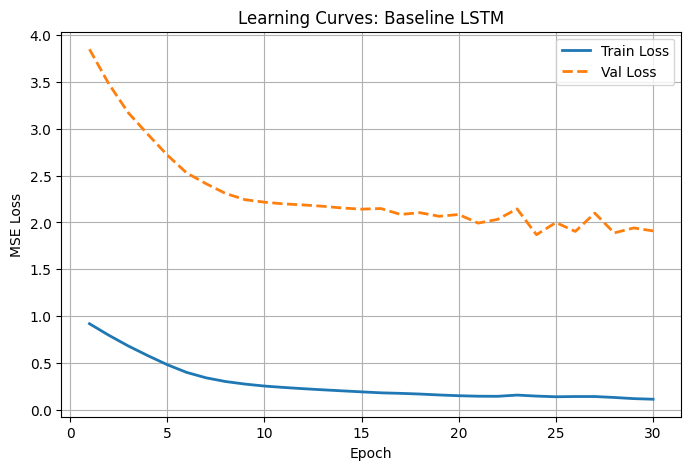

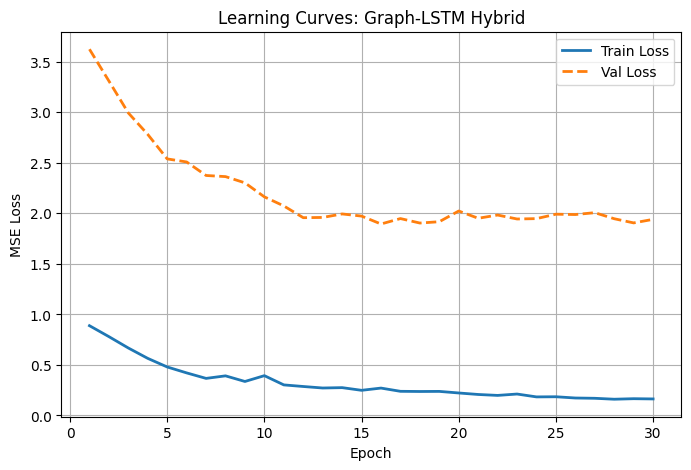

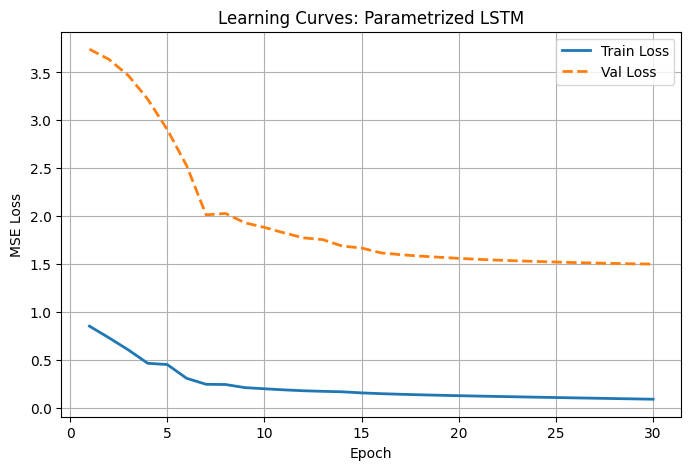

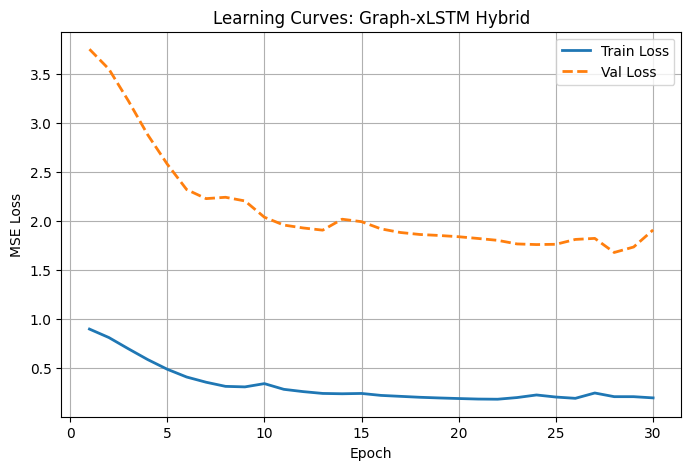

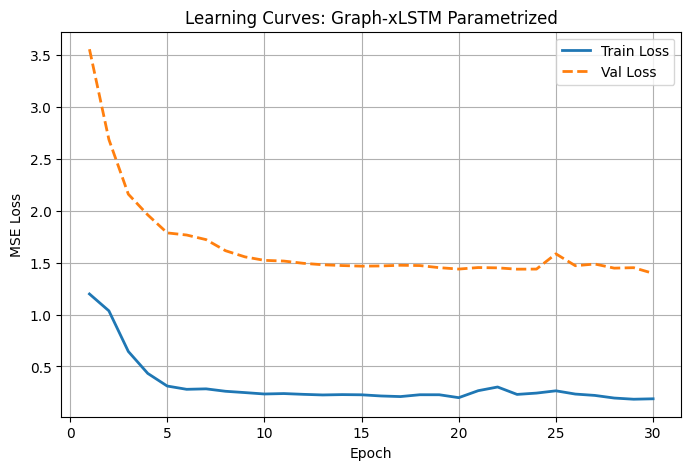

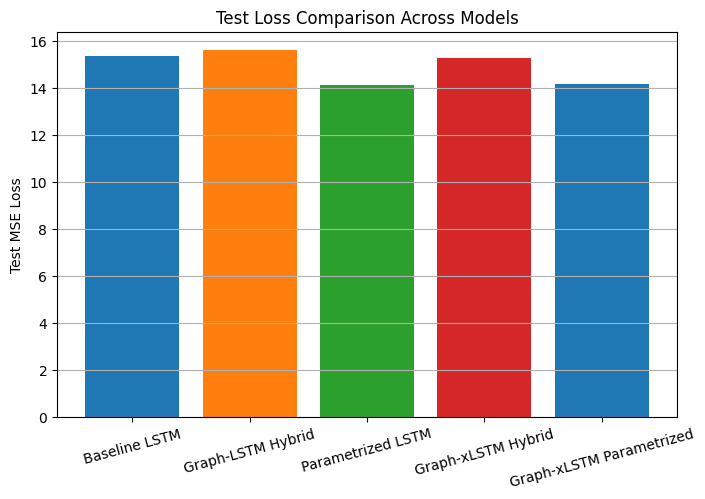

In [ ]:
def prepare_sample(sample, device):
    """
    Given one DynamicGraphTemporalSignal (or StaticGraphTemporalSignal) sample,
    return (x_tensor, y_tensor) where:
      - x_tensor: [1, S, N]
      - y_tensor: [1, N]
    We assume sample.x has shape [S, N, 1] or [batch_size, num_nodes, 1],
    and sample.y is either [N, batch_size] (many-to-many) or [N] (many-to-one).
    We interpret 'batch_size' = S for train (many-to-many), but we'll pick only the last column of y.
    """
    # features: sample.x → shape [S, N, 1] (numpy or tensor)
    # handle cases where sample.x might be a tensor directly
    if isinstance(sample.x, np.ndarray):
        x_np = sample.x
    elif torch.is_tensor(sample.x):
         x_np = sample.x.cpu().numpy() # Move to CPU before converting to numpy if on GPU
    else:
        raise TypeError("sample.x must be a numpy array or a torch tensor")

    # remove last dimension and reshape to [1, S, N]
    x_np = x_np.squeeze(-1)      # now [S, N]
    x_tensor = torch.from_numpy(x_np).unsqueeze(0).to(device)  # [1, S, N]

    # targets: sample.y
    # handle cases where sample.y might be a tensor directly
    if isinstance(sample.y, np.ndarray):
        y_np = sample.y
    elif torch.is_tensor(sample.y):
        y_np = sample.y.cpu().numpy() # Move to CPU before converting to numpy if on GPU
    else:
        raise TypeError("sample.y must be a numpy array or a torch tensor")

    # of y_np is 2D [N, batch_size], take the last column for many-to-one
    if y_np.ndim == 2:
        y_last = y_np[:, -1]            # [N]
    else:
        # if it’s already [N], just use it
        y_last = y_np                  # [N]
    y_tensor = torch.from_numpy(y_last).unsqueeze(0).to(device)  # [1, N]

    return x_tensor, y_tensor


def train_val_test_loop(models, train_samples, val_samples, test_samples,
                        epochs=30, lr=1e-3, device='cpu'):
    """
    models: dict of name → nn.Module
    train_samples, val_samples, test_samples: lists of samples from get_dataset(...)
    Each sample must have .x and .y attributes (numpy or tensor).
    """
    # criterion & optimizers for each model
    criterions = {name: nn.MSELoss() for name in models}
    optimizers = {
        name: torch.optim.Adam(model.parameters(), lr=lr)
        for name, model in models.items()
    }

    # containers for storing losses
    history = {
        name: {'train_losses': [], 'val_losses': [], 'test_loss': None}
        for name in models
    }

    train_data = [prepare_sample(s, device) for s in train_samples]
    val_data   = [prepare_sample(s, device) for s in val_samples]
    test_data  = [prepare_sample(s, device) for s in test_samples]


    # ------------ Training loop ------------
    for epoch in range(1, epochs + 1):
        for name, model in models.items():
            model.train()
            total_train_loss = 0.0

            # Loop over all training samples
            for (x_t, y_t) in train_data:
                # x_t: [1, S, N], y_t: [1, N]
                optimizers[name].zero_grad()
                pred = model(x_t)                     # [1, N]
                loss = criterions[name](pred, y_t)    # MSE
                loss.backward()
                optimizers[name].step()
                total_train_loss += loss.item()

            avg_train_loss = total_train_loss / len(train_data)
            history[name]['train_losses'].append(avg_train_loss)

        # ------------ Validation loop ------------
        for name, model in models.items():
            model.eval()
            total_val_loss = 0.0
            with torch.no_grad():
                for (x_v, y_v) in val_data:
                    pred_val = model(x_v)                     # [1, N]
                    loss_val = criterions[name](pred_val, y_v)
                    total_val_loss += loss_val.item()
            avg_val_loss = total_val_loss / len(val_data)
            history[name]['val_losses'].append(avg_val_loss)

        if epoch == 1 or epoch % 5 == 0 or epoch == epochs:
            print(f"Epoch {epoch}/{epochs}")
            for name in models:
                t_loss = history[name]['train_losses'][-1]
                v_loss = history[name]['val_losses'][-1]
                print(f"  {name:20s} | Train: {t_loss:.6f} | Val: {v_loss:.6f}")
            print("-" * 50)

    # ------------ Test loop ------------
    for name, model in models.items():
        model.eval()
        total_test_loss = 0.0
        with torch.no_grad():
            for (x_test, y_test) in test_data:
                pred_test = model(x_test)                    # [1, N]
                loss_test = criterions[name](pred_test, y_test)
                total_test_loss += loss_test.item()
        avg_test_loss = total_test_loss / len(test_data)
        history[name]['test_loss'] = avg_test_loss
        print(f"{name:20s} | Test Loss: {avg_test_loss:.6f}")

    return history

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# adjust corr_name and corr_scope as needed
data_dict = get_dataset('pcc', 'global')
train_samples = data_dict['train_samples']
val_samples   = data_dict['val_samples']
test_samples  = data_dict['test_samples']

# the shape of sample.x after squeeze(-1) is [S, N], where N is num_nodes
num_nodes = train_samples[0].x.shape[1]
hidden_dim = 32 # Define hidden_dim as previously intended
rank       = 16
hidden_size = num_nodes
K = 1 # previously was 2 but after printing the learned coefficient it turned out that probably 1-hop is better [STILL TO BE TESTED]

adj_matrix = train_samples[0].edge_attr.reshape(num_nodes, num_nodes)

# instantiate models
models = {
    'Baseline LSTM': Baseline_LSTM(num_nodes=num_nodes, hidden_dim=hidden_dim).to(device),
    'Graph-LSTM Hybrid': Graph_LSTM(num_nodes=num_nodes, hidden_dim=hidden_dim, GSO=adj_matrix).to(device),
    'Parametrized LSTM': Graph_LSTM_Parametrized(GSO=adj_matrix, hidden_size=hidden_size, K=K).to(device),
    'Graph-xLSTM Hybrid': Graph_xLSTM(num_nodes=num_nodes, hidden_dim=hidden_dim, rank=rank, A=adj_matrix).to(device),
    'Graph-xLSTM Parametrized': Graph_xLSTM_Param(GSO=adj_matrix, hidden_size=num_nodes, K=K).to(device)
}


history = train_val_test_loop(
    models=models,
    train_samples=train_samples,
    val_samples=val_samples,
    test_samples=test_samples,
    epochs=30,
    lr=1e-3,
    device=device
)

for name, h in history.items():
    epochs_range = range(1, len(h['train_losses']) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs_range, h['train_losses'], label='Train Loss', linewidth=2)
    plt.plot(epochs_range, h['val_losses'],   '--', label='Val Loss',   linewidth=2)
    plt.title(f"Learning Curves: {name}")
    plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
    plt.legend(); plt.grid(True)
    plt.show()

# compare test losses
model_names = list(history.keys())
test_losses = [history[n]['test_loss'] for n in model_names]

plt.figure(figsize=(8, 5))
plt.bar(model_names, test_losses, color=['C0','C1','C2','C3'])
plt.ylabel('Test MSE Loss')
plt.title('Test Loss Comparison Across Models')
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.show()

In [ ]:
# after training, print theta_x and theta_h for one gate
print("theta_x (gate 0):", models['Graph-xLSTM Parametrized'].cell.theta_x[0].detach().cpu().numpy())
print("theta_h (gate 0):", models['Graph-xLSTM Parametrized'].cell.theta_h[0].detach().cpu().numpy())


theta_x (gate 0): [-0.03167212 -0.01666014 -0.07424638]
theta_h (gate 0): [ 0.06333213  0.00995889 -0.09109942]
